# The Sed object

This example demonstrates the various methods associated with the `Sed` class.

`Sed` objects can be extracted directly from [Grid objects](../grids/grids.rst) or created by [Galaxy objects](../galaxy/galaxy.rst).

We start by loading some modules and initialising a grid:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from synthesizer.emission_models.attenuation.igm import Madau96
from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.sed import Sed, plot_spectra_as_rainbow
from unyt import Angstrom, eV, um

grid_dir = "../../../tests/test_grid/"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)

Next, let's extract the spectra at a given point in our grid.
We first define a target age and metallicity, obtain the index of the grid at these values, then extract the spectra.
This will be in the form of an ``Sed`` object.

In [2]:
log10age = 6.0  # log10(age/yr)
metallicity = 0.01
spectra_id = "incident"
grid_point = grid.get_grid_point((log10age, metallicity))
sed = grid.get_spectra(grid_point, spectra_id=spectra_id)
sed.lnu *= 1e8  # multiply initial stellar mass

print(sed)

+-------------------------------------------------------------------------------+
|                                      SED                                      |
+-------------+-----------------------------------------------------------------+
| Attribute   | Value                                                           |
+-------------+-----------------------------------------------------------------+
| redshift    | 0                                                               |
+-------------+-----------------------------------------------------------------+
| lam (9244,) | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+-------------+-----------------------------------------------------------------+
| nu (9244,)  | 1.00e+07 Hz -> 2.31e+22 Hz (Mean: 8.51e+19 Hz)                  |
+-------------+-----------------------------------------------------------------+
| lnu (9244,) | 0.00e+00 erg/(Hz*s) -> 3.10e+29 erg/(Hz*s) (Mean: 9.16e+27 erg) |
+-------------+-

`Sed` objects contain a wavelength grid and luminosity in the `lam` and `lnu` attributes. Both come with units making them easy to convert:

In [3]:
print(sed.lam)
print(sed.lnu)

[1.29662e-04 1.33601e-04 1.37660e-04 ... 2.97304e+11 2.98297e+11
 2.99293e+11] Å
[0. 0. 0. ... 0. 0. 0.] erg/(Hz*s)


These also have more descriptive aliases:

In [4]:
print(sed.wavelength)
print(sed.luminosity_nu)

[1.29662e-04 1.33601e-04 1.37660e-04 ... 2.97304e+11 2.98297e+11
 2.99293e+11] Å
[0. 0. 0. ... 0. 0. 0.] erg/(Hz*s)


Thus we can easily make a plot:

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


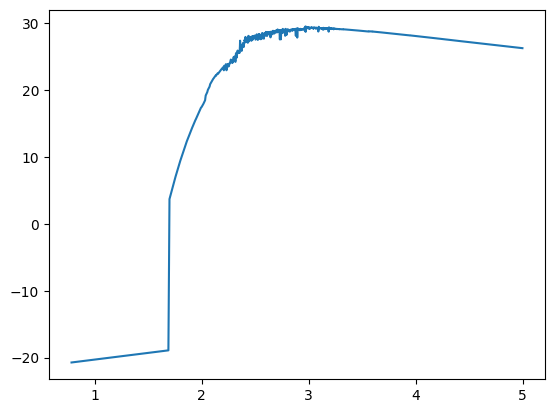

In [5]:
plt.plot(np.log10(sed.lam), np.log10(sed.lnu))
plt.show()

We can also also visualise the spectrum as a rainbow.

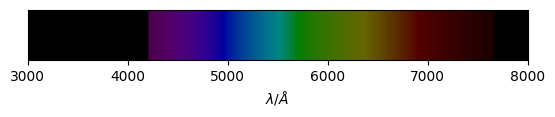

In [6]:
fig, ax = plot_spectra_as_rainbow(sed)
plt.show()

We can also get the luminosity ($L$) or spectral luminosity density per $\AA$ ($L_{\lambda}$): 

In [7]:
print(sed.luminosity)
print(sed.llam)

[0. 0. 0. ... 0. 0. 0.] erg/s
[0. 0. 0. ... 0. 0. 0.] erg/(s*Å)


``Sed`` objects can be easily scaled via the `*` operator. For example,

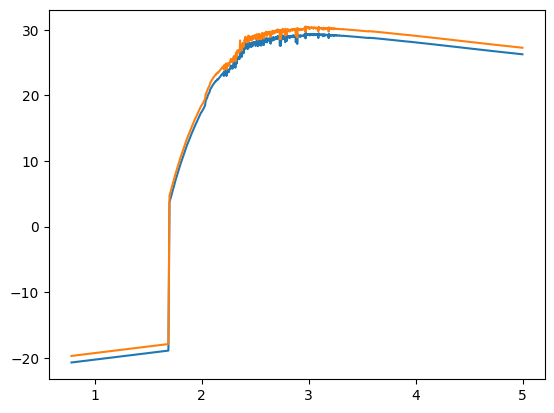

In [8]:
sed_x_10 = sed * 10

plt.plot(np.log10(sed.lam), np.log10(sed.lnu))
plt.plot(np.log10(sed_x_10.lam), np.log10(sed_x_10.lnu))
plt.show()

## Methods

There are a number of helper methods on ``Sed`` for calculating common derived properties. We provide some examples below.

We can calculate the integrated bolometric luminosity of the Sed:

In [9]:
sed.measure_bolometric_luminosity()

unyt_quantity(7.01614828e+44, 'erg/s')

By default any spectra integration will use a trapezoid method. It's also possible to use the simpson rule.

In [10]:
sed.measure_bolometric_luminosity(integration_method="simps")

unyt_quantity(7.01614828e+44, 'erg/s')

You can also get the luminosity or `lnu` in a particular window by passing the wavelengths defining the limits of the window.

In [11]:
sed.measure_window_luminosity((1400.0 * Angstrom, 1600.0 * Angstrom))

unyt_quantity(4.0480619e+43, 'erg/s')

Notice how units were provided with this window. These are required but also allow you to use an arbitrary unit system.

In [12]:
sed.measure_window_luminosity((0.14 * um, 0.16 * um))

unyt_quantity(4.0480619e+43, 'erg/s')

In [13]:
sed.measure_window_lnu((1400.0 * Angstrom, 1600.0 * Angstrom))

unyt_quantity(1.51428832e+29, 'erg/(Hz*s)')

As for the bolometric luminosity, there are multiple integration methods that can be used for calculating the window.
By default synthesizer will use the trapezoid method (`"trapz"`), but you can also take a simple average.

In [14]:
sed.measure_window_lnu(
    (1400.0 * Angstrom, 1600.0 * Angstrom), integration_method="average"
)

unyt_quantity(1.5142835e+29, 'erg/(Hz*s)')

We can measure a spectral break by providing two windows:

In [15]:
sed.measure_break((3400, 3600) * Angstrom, (4150, 4250) * Angstrom)

np.float64(0.8556966386986625)

There are also a few in-built break methods, e.g. `measure_Balmer_break()`

In [16]:
sed.measure_balmer_break()

np.float64(0.8556966386986625)

In [17]:
sed.measure_d4000()

np.float64(0.9014335946523934)

We can also measure absorption line indices, and spectral slopes (e.g. the UV spectral slope $\beta$):

In [18]:
sed.measure_index(
    (1500, 1600) * Angstrom, (1400, 1500) * Angstrom, (1600, 1700) * Angstrom
)

unyt_quantity(5.80884398, 'Å')

In [19]:
sed.measure_beta()

np.float64(-2.9472901626578625)

By default this uses a single window and fits the spectrum by a power-law. However, we can also specify two windows as below, in which case the luminosity in each window is calcualted and used to infer a slope:

In [20]:
sed.measure_beta(window=(1250, 1750, 2250, 2750))

np.float64(-2.9533621846623594)

Finally, we can also measure ionising photon production rates at a particular ionisation energy:

In [21]:
sed.calculate_ionising_photon_production_rate(
    ionisation_energy=13.6 * eV, limit=1000
)

unyt_quantity(9.8212605e+54, '1/s')

## Observed frame SED

By default ``Sed`` objects are defined in the rest frame. 
To move an SED to the observer frame we need to provide a cosmology, using an `astropy.cosmology` object, a redshift $z$, and optionally an IGM absorption model (see [here](../attenuation/igm.ipynb) for details).

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


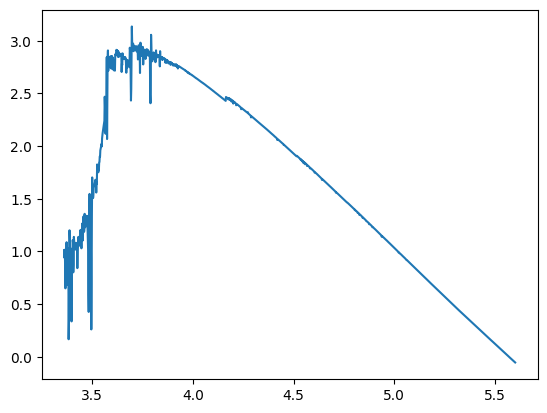

In [22]:
from astropy.cosmology import Planck18 as cosmo

z = 3.0  # redshift
sed.get_fnu(cosmo, z, igm=Madau96)  # generate observed frame spectra

plt.plot(np.log10(sed.obslam), np.log10(sed.fnu))
plt.show()

## Photometry

Once we have computed the observed frame SED there is a method on an `Sed` object that allows us to calculate observed photometry (the same is of course true for rest frame photometry). However, first we need to instantiate a `FilterCollection` object (see [Filters](../filters/filters.rst) for details):

In [23]:
filter_codes = [
    f"JWST/NIRCam.{f}"
    for f in [
        "F070W",
        "F090W",
        "F115W",
        "F150W",
        "F200W",
        "F277W",
        "F356W",
        "F444W",
    ]
]  # define a list of filter codes
fc = FilterCollection(filter_codes, new_lam=grid.lam)

# Measure observed photometry
fluxes = sed.get_photo_fluxes(fc)
print(fluxes)

------------------------------------------------------------------
|                       PHOTOMETRY (FLUX)                        |
|------------------------------------|---------------------------|
| JWST/NIRCam.F070W (λ = 7.04e+03 Å) | 6.76e-30 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F090W (λ = 9.02e+03 Å) | 5.34e-30 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F115W (λ = 1.15e+04 Å) | 3.86e-30 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F150W (λ = 1.50e+04 Å) | 2.77e-30 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F200W (λ = 1.99e+04 Å) | 1.90e-30 erg/(Hz*cm**2*s) |
|------------------------------------|---------------------------|
| JWST/NIRCam.F277W (λ = 2.76e+04 Å) | 1.10e-30 erg/(Hz*cm**2*s) |
|------------------------------------|------------------------

## Multiple SEDs

An ``Sed`` object can be composed of multiple SEDs ,if their dimensions are identical (i.e. same wavelength resolution).

To demonstrate, let's create an `Sed` object with two seds:

In [24]:
sed2 = Sed(sed.lam, np.array([sed.lnu, sed.lnu * 2]))

sed2.measure_window_lnu((1400, 1600) * Angstrom)
sed2.measure_beta()
sed2.measure_beta(window=(1250, 1750, 2250, 2750))
sed2.measure_balmer_break()
sed2.measure_index(
    (1500, 1600) * Angstrom, (1400, 1500) * Angstrom, (1600, 1700) * Angstrom
)

unyt_array([5.80884398, 5.80884398], 'Å')

## Combining SEDs

``Sed`` objects can be combined either via concatenation, to produce a single ``Sed`` holding multiple spectra, or by addition, to add the spectra contained in the input ``Sed`` objects. 

To concatenate spectra we use ``Sed.concat()``. 
`Sed.concat` can take an arbitrary number of `Sed` objects to combine.

In [25]:
print("Shapes before:", sed._lnu.shape, sed2._lnu.shape)
sed3 = sed2.concat(sed)
print("Combined shape:", sed3._lnu.shape)

sed4 = sed2.concat(sed, sed2, sed3)
print("Combined shape:", sed4._lnu.shape)

Shapes before: (9244,) (2, 9244)
Combined shape: (3, 9244)
Combined shape: (8, 9244)


If we want to add the spectra of two ``Sed`` objects together, we simply apply the `+` operator.
However, unlike `concat`, this will only work for ``Sed``s with identical shapes.

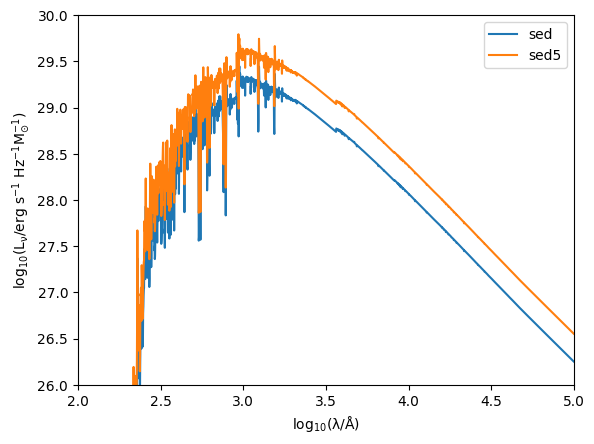

In [26]:
sed_add = sed + sed
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="sed")
plt.plot(np.log10(sed_add.lam), np.log10(sed_add.lnu), label="sed5")
plt.ylim(26, 30)
plt.xlim(2, 5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

## Resampling SEDs

The `Sed` includes a method to resample an sed, e.g. to lower-resolution or to match some target resolution (e.g. from observations).


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 




Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



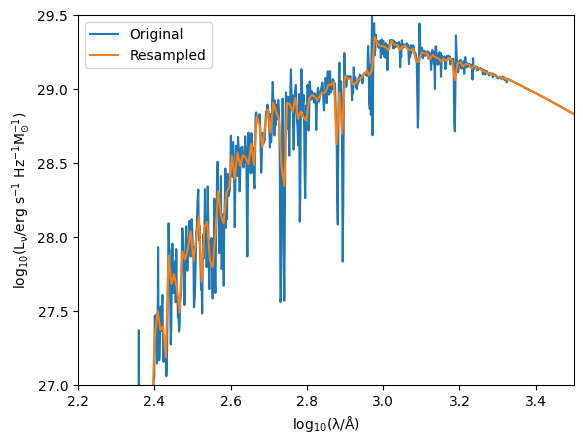

In [27]:
sed_resampled = sed.get_resampled_sed(5)
plt.plot(np.log10(sed.lam), np.log10(sed.lnu), label="Original")
plt.plot(
    np.log10(sed_resampled.lam), np.log10(sed_resampled.lnu), label="Resampled"
)
plt.xlim(2.2, 3.5)
plt.ylim(27.0, 29.5)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

In [28]:
print(
    sed.measure_bolometric_luminosity() / sed3.measure_bolometric_luminosity()
)

[1.  0.5 1. ] dimensionless


## Applying attenuation

To apply attenuation to an `Sed` you can use the `apply_attenuation` method and pass the optical depth and a dust curve (see [Attenuation](../attenuation/dust_attenuation.ipynb) for more details on dust curves).

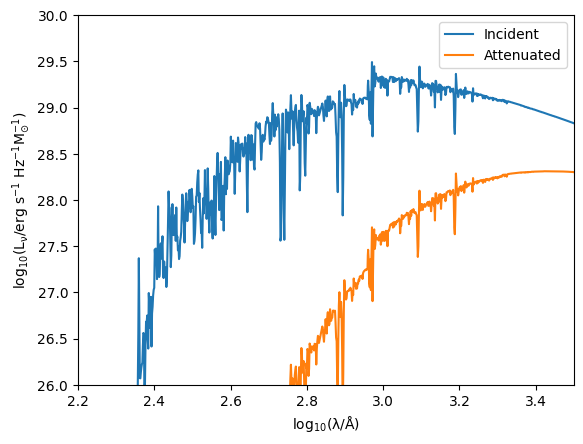

In [29]:
from synthesizer.emission_models.attenuation import PowerLaw

sed4_att = sed4.apply_attenuation(tau_v=0.7, dust_curve=PowerLaw(-1.0))

plt.plot(np.log10(sed4.lam), np.log10(sed4.lnu[0, :]), label="Incident")
plt.plot(
    np.log10(sed4_att.lam), np.log10(sed4_att.lnu[0, :]), label="Attenuated"
)
plt.xlim(2.2, 3.5)
plt.ylim(26.0, 30.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

``apply_attenuation`` can also accept a ``mask``, which applies attenuation to specific spectra in a multidimensional ``Sed`` (like an `Sed` containing the spectra for multiple particles, for instance.)

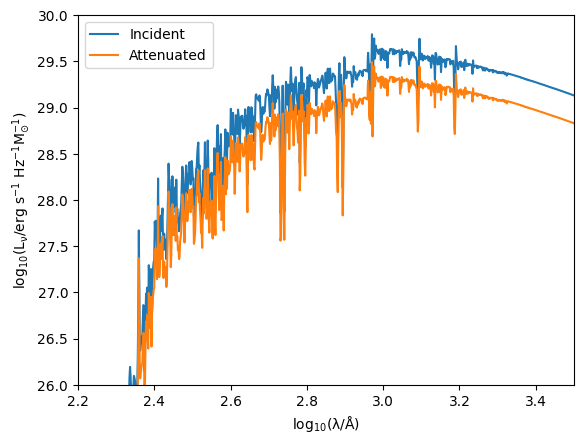

In [30]:
sed0_att = sed4.apply_attenuation(
    tau_v=0.7,
    dust_curve=PowerLaw(-1.0),
    mask=np.array([0, 1, 0, 0, 0, 0, 0, 0], dtype=bool),
)

plt.plot(np.log10(sed4.lam), np.log10(sed4.lnu[1, :]), label="Incident")
plt.plot(np.log10(sed4.lam), np.log10(sed0_att.lnu[0, :]), label="Attenuated")
plt.xlim(2.2, 3.5)
plt.ylim(26.0, 30.0)
plt.xlabel(r"$\rm log_{10}(\lambda/\AA)$")
plt.ylabel(r"$\rm log_{10}(L_{\nu}/erg\ s^{-1}\ Hz^{-1} M_{\odot}^{-1})$")
plt.legend()
plt.show()
plt.close()

## Calculating transmission

If you have an attenuated SED, a natural quantity to calculate is the extinction of that spectra ($A$). This can be done either at the wavelengths of the `Sed`, an arbitrary wavelength/wavelength array, or at commonly used values (1500 and 5500 angstrom) using functions available in the `sed` module. Note that these functions return the extinction/attenuation in magnitudes. Below is a demonstration.

In [31]:
from synthesizer.sed import (
    get_attenuation,
    get_attenuation_at_1500,
    get_attenuation_at_5500,
    get_attenuation_at_lam,
)
from unyt import angstrom, um

# Get an intrinsic spectra
grid_point = grid.get_grid_point((7, 0.01))
int_sed = grid.get_spectra(grid_point, spectra_id="incident")

# Apply an attenuation curve
att_sed = int_sed.apply_attenuation(tau_v=0.7, dust_curve=PowerLaw(-1.0))

# Get attenuation at sed.lam
attenuation = get_attenuation(int_sed, att_sed)

# Get attenuation at 5 microns
att_at_5 = get_attenuation_at_lam(5 * um, int_sed, att_sed)

# Get attenuation at an arbitrary range of wavelengths
att_at_range = get_attenuation_at_lam(
    np.linspace(5000, 10000, 5) * angstrom, int_sed, att_sed
)

# Get attenuation at 1500 angstrom
att_at_1500 = get_attenuation_at_1500(int_sed, att_sed)

# Get attenuation at 5500 angstrom
att_at_5500 = get_attenuation_at_5500(int_sed, att_sed)

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
